--- AI-Powered Mastitis Detection Model ---

[SUCCESS] Dataset loaded successfully.
Shape of the dataset: (6600, 18)

[INFO] Starting feature engineering...
New features created: 'avg_all_sensors', 'diff_fl', 'diff_fr', 'diff_rl', 'diff_rr', 'max_diff'

[INFO] Preparing data for the model...
Features used for training: Day, Months after giving birth, Previous_Mastits_status, Temperature, IUFL, EUFL, IUFR, EUFR, IURL, EURL, IURR, EURR, avg_all_sensors, diff_fl, diff_fr, diff_rl, diff_rr, max_diff, Breed

[INFO] Building and training the XGBoost model...

--- Model Performance (5-Fold Cross-Validation) ---
Mean ROC AUC: 0.9929 (+/- 0.0086)
This score shows the model's ability to distinguish between healthy and mastitis-affected cows.

[INFO] Training final model on the entire dataset...
[SUCCESS] Final model trained.


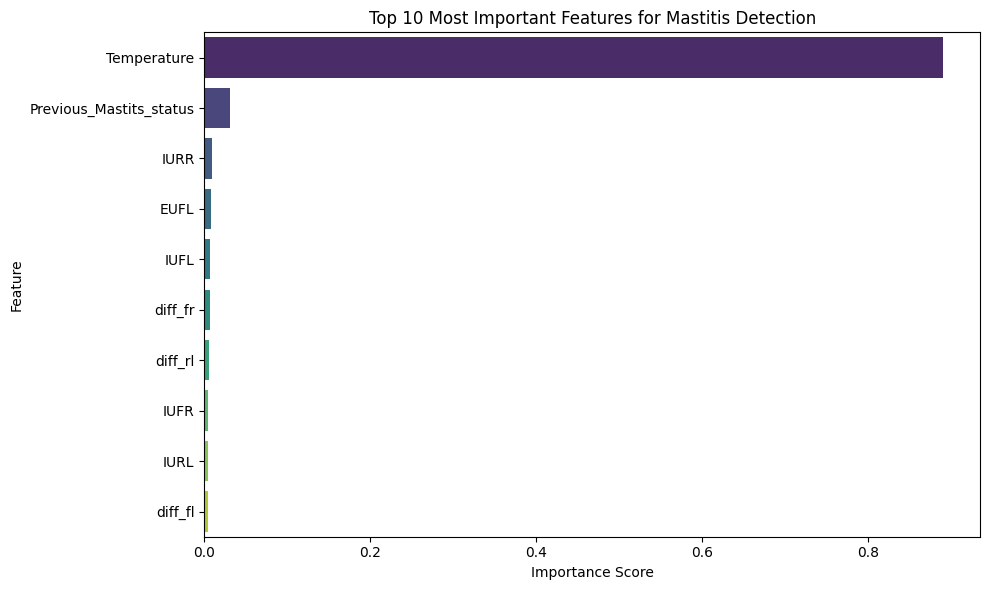


[SUCCESS] Model saved as 'mastitis_detection_model.joblib'. You can now use this file for predictions.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import xgboost as xgb
import joblib # To save the model

print("--- AI-Powered Mastitis Detection Model ---")

# --- 1. Load and Inspect Data ---
try:
    df = pd.read_csv('/kaggle/input/disease/clinical_mastitis_cows_version1.csv')
    print("\n[SUCCESS] Dataset loaded successfully.")
    print("Shape of the dataset:", df.shape)
except FileNotFoundError:
    print("\n[ERROR] 'clinical_mastitis_cows_version1.csv' not found. Please upload the dataset.")
    exit()

# --- 2. Feature Engineering ---
# Creating features that can capture inflammation patterns and sensor anomalies.
print("\n[INFO] Starting feature engineering...")
df['avg_all_sensors'] = df[['IUFL', 'EUFL', 'IUFR', 'EUFR', 'IURL', 'EURL', 'IURR', 'EURR']].mean(axis=1)
df['diff_fl'] = df['IUFL'] - df['EUFL']
df['diff_fr'] = df['IUFR'] - df['EUFR']
df['diff_rl'] = df['IURL'] - df['EURL']
df['diff_rr'] = df['IURR'] - df['EURR']
df['max_diff'] = df[['diff_fl', 'diff_fr', 'diff_rl', 'diff_rr']].abs().max(axis=1)
print("New features created: 'avg_all_sensors', 'diff_fl', 'diff_fr', 'diff_rl', 'diff_rr', 'max_diff'")

# --- 3. Model Preparation ---
print("\n[INFO] Preparing data for the model...")

# STRATEGIC CHOICE: We focus on an *early detection* model.
# We exclude features like Hardness, Pain, and Milk_visibility because they are
# clinical signs a farmer would see. A model that predicts before these signs
# appear is more valuable.
features_for_model = [
    'Day', 'Months after giving birth', 'Previous_Mastits_status',
    'Temperature', 'IUFL', 'EUFL', 'IUFR', 'EUFR', 'IURL', 'EURL', 'IURR', 'EURR',
    'avg_all_sensors', 'diff_fl', 'diff_fr', 'diff_rl', 'diff_rr', 'max_diff',
    'Breed'
]

X = df[features_for_model]
y = df['class1']
groups = df['Cow_ID'] # Essential for GroupKFold to prevent data leakage

print(f"Features used for training: {', '.join(features_for_model)}")

# Identify categorical and numerical features for the preprocessor
categorical_features = ['Breed']
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

# Create a preprocessing pipeline to scale numerical data and one-hot encode categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# --- 4. Model Training and Evaluation (XGBoost) ---
print("\n[INFO] Building and training the XGBoost model...")

# Create the full pipeline including the preprocessor and the classifier
# Using XGBoost as it's powerful and often wins hackathons
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(use_label_encoder=False, 
                                     eval_metric='logloss',
                                     objective='binary:logistic',
                                     n_estimators=100,
                                     learning_rate=0.1,
                                     max_depth=5,
                                     random_state=42))
])

# Use GroupKFold for robust cross-validation. This is CRITICAL.
# It ensures all records for a single cow are in either the training or testing set,
# giving a more realistic measure of performance on unseen cows.
gkf = GroupKFold(n_splits=5)
cv_scores = cross_val_score(xgb_pipeline, X, y, cv=gkf, groups=groups, scoring='roc_auc')

print("\n--- Model Performance (5-Fold Cross-Validation) ---")
print(f"Mean ROC AUC: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")
print("This score shows the model's ability to distinguish between healthy and mastitis-affected cows.")

# --- 5. Final Model Training and Analysis ---
# Now, train the final model on all data to get feature importances and save it
print("\n[INFO] Training final model on the entire dataset...")
xgb_pipeline.fit(X, y)
print("[SUCCESS] Final model trained.")

# Extract feature names after one-hot encoding
try:
    ohe_feature_names = xgb_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
    final_feature_names = numerical_features + list(ohe_feature_names)
    
    # Get feature importances from the trained XGBoost model
    importances = xgb_pipeline.named_steps['classifier'].feature_importances_
    feature_importance_df = pd.DataFrame({'feature': final_feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False).head(10)

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
    plt.title('Top 10 Most Important Features for Mastitis Detection')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\nCould not generate feature importance plot. Error: {e}")


# --- 6. Save the Model ---
# This saved model can later be loaded into a UI or API.
model_filename = 'mastitis_detection_model.joblib'
joblib.dump(xgb_pipeline, model_filename)
print(f"\n[SUCCESS] Model saved as '{model_filename}'. You can now use this file for predictions.")
